In [3]:
# Skriptas užduoto ilgio sekų skaitymui iš MIT2ZIVE EKG įrašų plius papildomi skriptai

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from wfdb_plot import plot_items
from pathlib import Path
import sys

from mit2zive_util import read_show_seq_ext_mit2zive

def read_seq(rec_dir, all_beats_attr, idx, wl_side, wr_side):
# nuskaito EKG seką apie R dantelį: wl_side - iš kairės pusės, wr_side - iš dešinės pusės
    row = all_beats_attr.loc[idx]

    file_path = Path(rec_dir, str(row['userNr']) + '.npa')
    signal = np.load(file_path, mmap_mode='r')    

    signal_length = signal.shape[0]

    (seq_start, seq_end)  = get_seq_start_end(signal_length, row['sample'], wl_side, wr_side)
        
    # Praleidžiame per trumpas sekas įrašo pradžioje ir pabaigoje
    if (seq_start == None or seq_end == None):
        return None, None 
    else:    
        seq = signal[seq_start:seq_end]
        label = row['label']
    return seq, label


def get_seq_start_end(signal_length,i_sample,window_left_side,window_right_side):
    # Nustatome išskiriamos EKG sekos pradžią ir pabaigą
    seq_start = i_sample - window_left_side
    seq_end = i_sample + window_right_side
    if (seq_start < 0 or seq_end > signal_length):
        # print("\nseq_start: ", seq_start, " seq_end: ", seq_end)
        return (None,None)
    else:    
        return (seq_start, seq_end)


def plot_seq(rec_dir, all_beats_attr, idx, wl_side, wr_side, window_left_side_ext, window_right_side_ext):
# 'Išpjauname' užduoto ilgio seką ir sukuriame jos vaizdą
    row = all_beats_attr.loc[idx]
    userNr = str(row['userNr'])
    sample = row['sample']
    # print(userNr, sample)

    fig = plt.figure(facecolor=(1, 1, 1), figsize=(18,3)) 
    ax = read_show_seq_ext_mit2zive(rec_dir, userNr, sample, wl_side, wr_side, 
                                                                window_left_side_ext, window_right_side_ext)
    if (ax == None):
        print(f"Sekai userNr: {userNr}  idx: {idx} negali suformuoti išplėstinio vaizdo")
    else:
        txt = f"{'userNr:'} {str(userNr)}  {'idx:'} {str(idx)}"
        plt.title(txt)
        plt.show()    


def read_show_seq_ext_mit2zive(rec_dir, subject, i_sample, win_ls, win_rs, win_ls_ext, win_rs_ext):
# Išpjauna užduoto ilgio seką iš mit2zive įrašo ir sukuria jos vaizdą su anotacijomis

# rec_dir - paciento EKG įrašų aplankas
# subject - paciento EKG įrašo numeris - int
# i_sample - R dantelio, kurio atžvilgiu formuojama seka, indeksas viso EKG įrašo reikšmių masyve - int
# win_ls - klasifikuojamo EKG segmento plotis iki R pūpsnio (iš kairės) 
# win_rs - klasifikuojamo EKG segmento plotis nuo R pūpsnio (iš dešinės)
# win_ls_ext - vaizduojamo EKG segmento plotis iki R pūpsnio (iš kairės) 
# win_rs_ext - vaizduojamo EKG segmento plotis už R pūpsnio (iš dešinės) 

    ax = plt.gca()
    
 # Nuskaitome visą paciento įrašą 
    file_path = Path(rec_dir, str(subject) + '.npy')
    signal = np.load(file_path, mmap_mode='r')    
    signal_length = signal.shape[0]

    # Nuskaitome paciento anotacijas ir jų indeksus
    file_path = Path(rec_dir, str(subject) + '.json')
    df = pd.read_json(file_path, orient = 'records')
    atr_sample = df['sampleIndex'].to_numpy()
    atr_symbol = df['annotationValue'].to_numpy()

    # surandame užduoto ilgio sekos pradžią ir pabaigą,
    # jei reikia - koreguojame
    seq_start, seq_end = get_seq_start_end(signal_length, i_sample, win_ls_ext, win_rs_ext)
    if (seq_start == None or seq_end == None):
        print("klaida!")
        return None

    # Išskiriame seką
    sequence = signal[seq_start:seq_end]

    # # suformuojame anotacijų žymes
    beat_symbols,beat_locs = get_symbol_list(atr_symbol,atr_sample, seq_start, seq_end)

    # deltax ir deltay simbolių pozicijų koregavimui
    min = np.amin(sequence)
    max = np.amax(sequence)
    deltay = (max - min)/20
    deltax = len(sequence)/100

    # suformuojame vaizdą
    x = np.arange(0, len(sequence), 1)
    ax.plot(x, sequence, color="#6c3376", linewidth=2)
    left_mark = i_sample - seq_start - win_ls
    right_mark = i_sample - seq_start + win_rs
    ax.axvline(x = left_mark, color = 'b', linestyle = 'dotted')
    ax.axvline(x = right_mark, color = 'b', linestyle = 'dotted')
    for i in range(len(beat_locs)):
        ax.annotate(beat_symbols[i],(beat_locs[i]-deltax,sequence[beat_locs[i]]+deltay))
    ax.set_ylim([min, max+2*deltay])
    
    return(ax)

def get_symbol_list(atr_symbols, atr_samples, seq_start, seq_end):
    # Surenkame išpjautos EKG sekos anotacijas ir jų indeksus sekoje
    # ir patalpiname sąraše.
    beat_locs = []
    beat_symbols = []

    for i in range(len(atr_samples)):
        if atr_samples[i] > seq_start and atr_samples[i] < seq_end:
            beat_symbols.append(atr_symbols[i])
            beat_locs.append(atr_samples[i]-seq_start)   
            # beat_locs.append(atr_samples[i])   

    return (beat_symbols,beat_locs)




def create_set(rec_dir, all_beats_attr, ind_lst, window_left_side, window_right_side):
    # Panaudojant sekų atributų freimą, sukuriamas užduoto ilgio sekų ir klasių numerių masyvai, 
    # tinkami klasifikatoriaus mokymui ir tikslumo vertinimui
    
    seq_length = window_left_side + window_right_side

    # Suformuojame failus pildymui
    set_len = len(ind_lst)
    X = np.empty((set_len, seq_length))
    y = np.empty((set_len), dtype=int)

    # Pildymas
    count = 0
    for idx in ind_lst:
        seq_1d, label = read_seq(rec_dir, all_beats_attr, idx, window_left_side, window_right_side)
        if (label != None):
            X[count,:] = seq_1d 
            y[count] = label
            count +=1
        else:
            print("Klaida!", idx)    

    # Koreguojame ilgius 
    X_set = np.resize(X, (count, seq_length))
    y_set = np.resize(y, (count))
    return X_set, y_set

def anotaciju_pasiskirstymas_v2(all_beats_attr, ind_lst=None, cols_pattern=None):
#  Skaičiuoja anotacijų pasiskirstymą
#  ind_lst - indeksų sąrašas, kuriuos reikia įtraukti į skaičiavimą

    if (ind_lst is not None):
        tmp_beats_attr = all_beats_attr.loc[all_beats_attr.index[ind_lst]]
        labels_table = pd.crosstab(index=tmp_beats_attr['userNr'], columns=tmp_beats_attr['symbol'], margins=True)
    else:
        labels_table = pd.crosstab(index=all_beats_attr['userNr'], columns=all_beats_attr['symbol'], margins=True)

    if (cols_pattern is not None):
        cols = list(labels_table.columns)
        cols_ordered = [s for s in cols_pattern if s in cols]
        labels_table = labels_table[cols_ordered]
    
    labels_sums = labels_table.sum(axis=1) 

    return labels_table, labels_sums
    

my_os=sys.platform

print("OS in my system : ",my_os)

if my_os != 'linux':
    OS = 'Windows'
else:  
    OS = 'Ubuntu'

# Pasiruošimas

# Bendras duomenų aplankas, kuriame patalpintas subfolderis name_db

if OS == 'Windows':
    Duomenu_aplankas = 'C:\DI\Data\MIT&ZIVE'   # variantas: Windows
else:
    Duomenu_aplankas = '/home/kesju/DI/Data/MIT&ZIVE'   # arba variantas: UBUNTU, be Docker

# jei variantas Docker pasirenkame:
# Duomenu_aplankas = '/Data/MIT&ZIVE'

#  MIT2ZIVE duomenų aplankas
db_folder = 'DUOM_VU'

# Nuoroda į DUOM_TST duomenų aplanką
db_path = Path(Duomenu_aplankas, db_folder)

# Anotacijoms priskirtos klasės
selected_beats = {'N':0, 'S':1, 'V':2}

print("\nBendras MIT ir Zive duomenų aplankas: ", Duomenu_aplankas)
print("MIT2ZIVE EKG įrašų aplankas: ", db_folder)


OS in my system :  win32

Bendras MIT ir Zive duomenų aplankas:  C:\DI\Data\MIT&ZIVE
MIT2ZIVE EKG įrašų aplankas:  DUOM_VU



Atsitiktinių sekų skaitymas ir jų statistikos skaičiavimas



idx = 46646  seq_1d.shape = (200,)  label = 0
DescribeResult(nobs=200, minmax=(-0.30839160258173054, 1.7617496559211054), mean=-0.14232087031412524, variance=0.09477850439554002, skewness=4.539055653601561, kurtosis=21.954204401561082)


idx = 64833  seq_1d.shape = (200,)  label = 0
DescribeResult(nobs=200, minmax=(-1.1882940702439095, 2.145093766183456), mean=-0.3430904768201599, variance=0.22138873833415423, skewness=2.0599605164663073, kurtosis=7.517602282986168)


idx = 63183  seq_1d.shape = (200,)  label = 0
DescribeResult(nobs=200, minmax=(-0.405, 1.4313182234827573), mean=-0.21655756810226506, variance=0.053480727048403114, skewness=4.160727096634437, kurtosis=23.20647414696684)

Anotacijų pasiskirstymas visuose duomenyse
symbol      N     S     V
userNr                   
100      2239    33     1
101      1860     3     0
103      2082     2     0
105      2526     0    41
106      1507     0   520
108      1740   

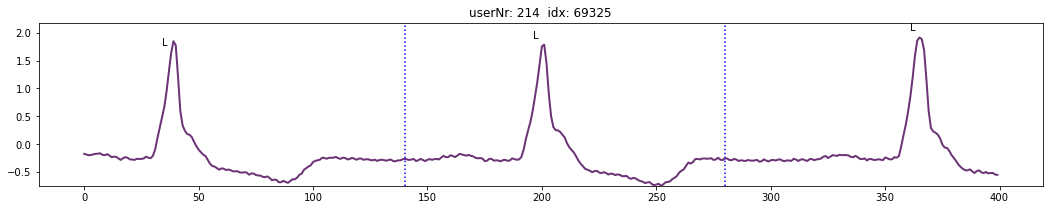

0:01:37.130000


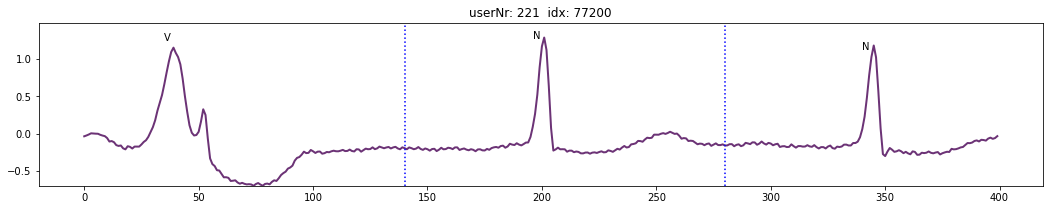

0:05:56.670000


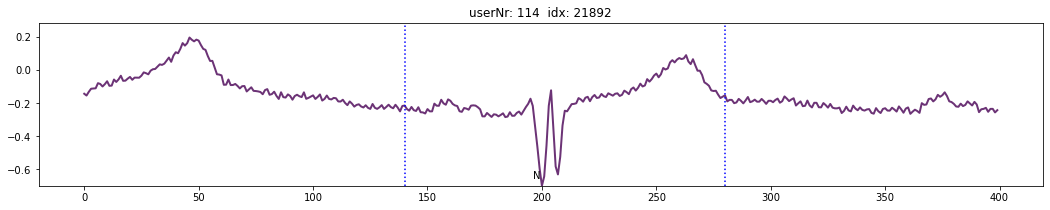


Mokymo imties sekų indeksų sąrašas įrašytas į:  C:\DI\Data\MIT&ZIVE\DUOM_VU\train_ind_lst.csv

Anotacijų pasiskirstymas mokymo duomenyse

{'N': 44282, 'S': 837, 'V': 3577}
48696

Mokymo imties dimensijos
X_train.shape=(48696, 140) y_train.shape=(48696,)

Mokymo sekų ir jų klasių numerių masyvas įrašytas: į  C:\DI\Data\MIT&ZIVE\DUOM_VU\train_set.npz

Kontrolinis mokymo imties skaitymas
Mokymo imties dimensijos
X_tr.shape=(48696, 140) y_tr.shape=(48696,)


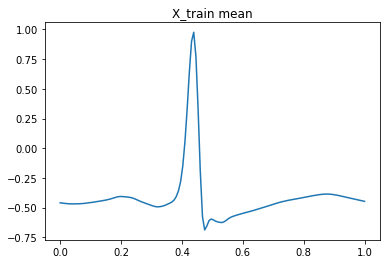


Vertinimo imties sekų indeksų sąrašas įrašytas į:  C:\DI\Data\MIT&ZIVE\DUOM_VU\validate_ind_lst.csv

Anotacijų pasiskirstymas vertinimo duomenyse

{'N': 44218, 'S': 1836, 'V': 3219}
49273

Vertinimo imties dimensijos
X_validate.shape=(49273, 140) y_validate.shape=(49273,)

Vertinimo sekų ir jų klasių numerių masyvas įrašytas: į  C:\DI\Data\MIT&ZIVE\DUOM_VU\validate_set.npz

Kontrolinis vertinimo imties skaitymas
Vertinimo imties dimensijos
X_va.shape=(49273, 140) y_va.shape=(49273,)


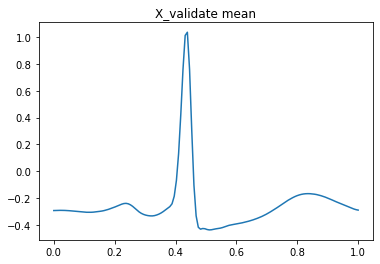

Pabaiga


In [4]:
import random
from scipy import stats
import datetime

# Įvairios operacijos

# Nuskaitome pūpsnių atributų failą
file_path = Path(db_path, 'all_beats_attr.csv')
all_beats_attr = pd.read_csv(file_path, index_col=0)

# I Nuskaito atsitiktinai parinktas sekas ir klasės nr
print("\nAtsitiktinių sekų skaitymas ir jų statistikos skaičiavimas\n")
wl_side, wr_side = 100, 100
randomlist = random.sample(range(0, len(all_beats_attr)), 3)

for idx in randomlist:
    seq_1d, label = read_seq(db_path, all_beats_attr, idx, wl_side, wr_side)
    print("\n")
    print(f"{'idx ='} {idx}  {'seq_1d.shape ='} {seq_1d.shape}  {'label ='} {label}")
    print(stats.describe(seq_1d))


# II Anotacijų pasiskirstymas visuose duomenyse
print("\nAnotacijų pasiskirstymas visuose duomenyse")
labels_table, labels_sums = anotaciju_pasiskirstymas_v2(all_beats_attr, cols_pattern=['N', 'S', 'V'])
print(labels_table)
print("\n", labels_sums)


# III Vaizdavimas

randomlist = random.sample(range(0, len(all_beats_attr)), 3)
# print(randomlist)

wl_side = 60
wr_side = 80
window_left_side_ext = 200
window_right_side_ext = 200

for idx in randomlist:
    seconds = all_beats_attr.loc[idx,'sample']/200.
    converted = datetime.timedelta(seconds=seconds)  # #  hour, minutes, and secondss
    print(converted)
    plot_seq(db_path, all_beats_attr, idx, wl_side, wr_side, window_left_side_ext, window_right_side_ext)


# IV Suformuojame mokymo ir vertinimo imtis

# Train imties pacientai
DS1 = [101, 106, 108, 109, 112, 114, 115, 116, 118, 119, 122, 124, 201, 203, 205, 208, 209, 215, 220, 223,230]

# Validate imties pacientai
DS2 = [100, 103, 105, 111, 113, 117, 121, 123, 200, 202, 210, 212, 213, 214, 219, 221, 222, 228, 231, 232, 233, 234]


# Kiekis pūpsnių, kurie atmetami EKG įrašo pradžioje ir pabaigoje
beats_skiped = 1

# Visi pūpsnių indeksai

# MOKYMO IMTIS

# Suformuojame mokymo imties sekų indeksų sąrašą. Formuodami sąrašą
# kiekvienam pacientui eliminuojame pirmus ir paskutinius beats_skiped indeksus
index_beats_attr = all_beats_attr.index
train_ind_lst = []
for userNr in DS1:
    selected_ind = index_beats_attr[all_beats_attr['userNr']==userNr]
    selected_ind = selected_ind[beats_skiped:-beats_skiped]
    train_ind_lst.extend(selected_ind.to_list())

# Įrašome mokymo imties sekų indeksų sąrašą į diską
file_path = Path(db_path, 'train_ind_lst.csv')
np.savetxt(file_path, np.array(train_ind_lst), delimiter=',', fmt='%d')
print("\nMokymo imties sekų indeksų sąrašas įrašytas į: ", file_path )

# Anotacijų pasiskirstymas mokymo duomenyse
print("\nAnotacijų pasiskirstymas mokymo duomenyse\n")
labels_table, labels_sums = anotaciju_pasiskirstymas_v2(all_beats_attr, ind_lst=train_ind_lst, cols_pattern=['N', 'S', 'V'])
# print(labels_table)
# print("\n", labels_sums)
print(dict(labels_table.loc['All']))
print(labels_sums.loc['All'])


# Suformuojame mokymo sekų ir jų klasių numerių masyvus
X_train, y_train = create_set(db_path, all_beats_attr, train_ind_lst, wl_side, wr_side)
print("\nMokymo imties dimensijos")
print(f"{X_train.shape=} {y_train.shape=}")

# Įrašome mokymui skirtus masyvus į npz file diske
file_path = Path(db_path, 'train_set.npz')
np.savez_compressed(file_path, X=X_train, y=y_train)
print("\nMokymo sekų ir jų klasių numerių masyvas įrašytas: į ", file_path )

# Kontrolinis nuskaitymas
print("\nKontrolinis mokymo imties skaitymas")
file_path = Path(db_path, 'train_set.npz')
dict_data = np.load(file_path)
X_tr = dict_data['X']
y_tr = dict_data['y']
print("Mokymo imties dimensijos")
print(f"{X_tr.shape=} {y_tr.shape=}")

# Apskaičiuojame mokymų sekų vidurkį ir nusibraižome
mean = X_tr.mean(axis=0)
xx = np.linspace(0, 1, len(mean))
plt.plot(xx, mean, label='linear')  # Plot some data on the (implicit) axes.
plt.title('X_train mean')
plt.show()


# VERTINIMO IMTIS

# Suformuojame vertinimo imties sekų indeksų sąrašą. Formuodami sąrašą
# kiekvienam pacientui eliminuojame pirmus ir paskutinius beats_skiped indeksus
validate_ind_lst = []
for userNr in DS2:
    selected_ind = index_beats_attr[all_beats_attr['userNr']==userNr]
    selected_ind = selected_ind[beats_skiped:-beats_skiped]
    validate_ind_lst.extend(selected_ind.to_list())

# Įrašome vertinimo imties sekų indeksų sąrašą į diską
file_path = Path(db_path, 'validate_ind_lst.csv')
np.savetxt(file_path, np.array(validate_ind_lst), delimiter=',', fmt='%d')
print("\nVertinimo imties sekų indeksų sąrašas įrašytas į: ", file_path )

# Anotacijų pasiskirstymas vertinimo duomenyse
print("\nAnotacijų pasiskirstymas vertinimo duomenyse\n")
labels_table, labels_sums = anotaciju_pasiskirstymas_v2(all_beats_attr, ind_lst=validate_ind_lst, cols_pattern=['N', 'S', 'V'])
# print(labels_table)
# print("\n", labels_sums)
print(dict(labels_table.loc['All']))
print(labels_sums.loc['All'])


# Suformuojame mokymo sekų ir jų klasių numerių masyvus
X_validate, y_validate = create_set(db_path, all_beats_attr, validate_ind_lst, wl_side, wr_side)
print("\nVertinimo imties dimensijos")
print(f"{X_validate.shape=} {y_validate.shape=}")

# Įrašome vertinimui skirtus masyvus į npz file diske
file_path = Path(db_path, 'validate_set.npz')
np.savez_compressed(file_path, X=X_validate, y=y_validate)
print("\nVertinimo sekų ir jų klasių numerių masyvas įrašytas: į ", file_path )

# Kontrolinis nuskaitymas
print("\nKontrolinis vertinimo imties skaitymas")
file_path = Path(db_path, 'validate_set.npz')
dict_data = np.load(file_path)
X_va = dict_data['X']
y_va = dict_data['y']
print("Vertinimo imties dimensijos")
print(f"{X_va.shape=} {y_va.shape=}")

# Apskaičiuojame vidurkį ir nusibraižome
mean = X_va.mean(axis=0)
xx = np.linspace(0, 1, len(mean))
plt.plot(xx, mean, label='linear')  # Plot some data on the (implicit) axes.
plt.title('X_validate mean')
plt.show()

print("Pabaiga")

